In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from torch.utils.data import DataLoader
# Add the path to utils.py
sys.path.append(r"c:\Document\Serieux\Travail\python_work\cEBNM_torch\py")

# Import utils.py directly
from utils import *
from numerical_routine import *
from distribution_operation import *
from posterior_computation import *

# Set random seed for reproducibility
np.random.seed(1)
torch.manual_seed(1)

batch_size=128
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = DataLoader(mnist_data, batch_size=batch_size , shuffle=True)

# Function to generate y values
def generate_y(t, is_even):
     
    if is_even:        
        if t <0 :
         return  np.random.normal(0, 2 )
        else :
            return np.zeros_like(t)
    else:
        if t>0:
            return np.random.normal(0, 2 )
        else :
            return  np.zeros_like(t)
        
 
# Custom Dataset class to handle MNIST images and simulated data
class SimulatedMNISTDataset(Dataset):
    def __init__(self, mnist_data, positions, y_values, y_noisy, digits, noise_level, label_type, image_label):
        self.image = mnist_data 
        self.mnist_data = mnist_data
        self.positions = torch.tensor(positions, dtype=torch.float32)
        self.y_values = torch.tensor(y_values, dtype=torch.float32)
        self.y_noisy = torch.tensor(y_noisy, dtype=torch.float32)
        self.digits = torch.tensor(digits, dtype=torch.long)
        self.noise_level = noise_level
        self.label_type = label_type
        self.image_label=image_label
        self.scale = autoselect_scales_mix_norm(
            betahat=np.array(self.y_noisy),
            sebetahat=np.array(self.noise_level)
        )
        
        self.Lim =torch.tensor(  get_data_loglik_normal(
            betahat=np.array(self.y_noisy),
            sebetahat=np.array(self.noise_level),
            location=0,
            scale=self.scale
                     ) , dtype=torch.float32)

    def __len__(self):
        return len(self.mnist_data)

    
    def __getitem__(self, idx):
        image, _ = self.mnist_data[idx]
        position = self.positions[idx]
        y_value = self.y_values[idx]
        y_noisy = self.y_noisy[idx]
        digit = self.digits[idx]
        marginal_log_lik = self.Lim[idx]
        
        return image, digit, position, y_value, y_noisy, marginal_log_lik
    

        



In [15]:
# Generate the simulated dataset
n_samples = 30000
noise_level = 1
positions = []
y_values = []
digits = []
y_noisy = []
label_type= []
image_label =[]
# Ensure unique indices are used
unique_indices = np.random.choice(len(mnist_data), size=n_samples, replace=False)
filtered_mnist_data = torch.utils.data.Subset(mnist_data, unique_indices)

# Run simulation to generate noisy data
for idx in unique_indices:
    image, label = mnist_data[idx]
    t = np.random.uniform(-0.5, 0.5)
    is_even = label % 2 == 0
    y = generate_y(t, is_even)
    noise = np.random.normal(0, noise_level)
    y_noisy_value = y + noise
    positions.append(t)
    y_values.append(y)
    y_noisy.append(y_noisy_value)
    digits.append(label)
    image_label.append(label)
    label_type.append(is_even)
    
positions = np.array(positions)
y_values = np.array(y_values)
y_noisy = np.array(y_noisy)
digits = np.array(digits)
label_type = np.array(label_type)
image_label = np.array(image_label)
noiseless=y_values
# Create custom dataset with the filtered MNIST dataset and simulated data
simulated_dataset = SimulatedMNISTDataset(
    mnist_data=filtered_mnist_data,
    positions=positions,
    y_values=y_values,
    y_noisy=y_noisy,
    digits=digits,
    noise_level=np.repeat(1, y_noisy.shape[0]),
    label_type=label_type,
    image_label =image_label
)


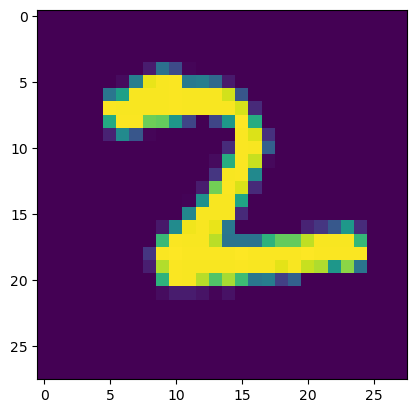

In [16]:
img, label =simulated_dataset.mnist_data[1]
img
plt.imshow(img.squeeze())

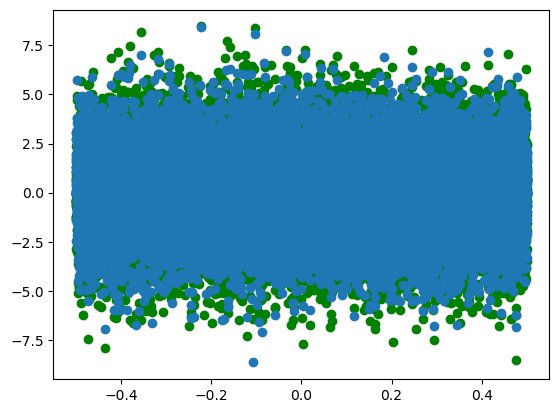

In [17]:
positions =simulated_dataset.positions
y_values = simulated_dataset.y_values
y_noisy = simulated_dataset.y_noisy

plt.scatter(positions, y_noisy, color="green")
plt.scatter(positions,y_values)

In [18]:
 
L_im = simulated_dataset.Lim
print(L_im [0])
scale= autoselect_scales_mix_norm(betahat=np.array(y_noisy),
                             sebetahat=np.repeat(1, y_noisy.shape[0]))
print(get_data_loglik_normal(y_noisy,  location=0,
                             sebetahat=np.repeat(1, y_noisy.shape[0]),
                             scale=scale)[0,])
      
 
n_epoch = 20
batch_size =128


tensor([-9.9796, -9.9424, -9.8327, -9.4215, -8.1232, -5.5716, -3.4243, -2.8679,
        -3.1861, -3.7807])
[-9.97964624 -9.94241715 -9.8327038  -9.42150697 -8.1232224  -5.57158147
 -3.4243323  -2.86791433 -3.18607763 -3.78071764]


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),  # +1 for position
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x, pos):
        x = x.view(x.size(0), -1)  # Flatten the image
        input_tensor = torch.cat([x, pos], dim=1)
        return F.softmax(self.network(input_tensor), dim=1)

# Loss function
def loss_function(pred_pi, marginal_log_lik):
    log_likelihood = torch.log(torch.sum(torch.exp(marginal_log_lik) * pred_pi, dim=1))
    return -torch.sum(log_likelihood)


def loss_function(pred_pi, marginal_log_lik, penalty=10, epsilon=1e-10):
    
    """
    Compute the penalized log likelihood function using vectorized operations.

    Parameters:
    pred_pi (torch.Tensor): A tensor of shape (batch_size, K) corresponding to pi_k for each sample.
    marginal_log_lik (torch.Tensor): A tensor of shape (batch_size, K) corresponding to the log-likelihoods.
    penalty (float): The penalty term.
    epsilon (float): Small constant to avoid log of zero or division by zero.

    Returns:
    torch.Tensor: The negative penalized log likelihood (for minimization purposes).
    """
    # Compute L_batch as the exponentiated marginal_log_lik (this is vectorized across all rows)
    L_batch = torch.exp(marginal_log_lik)

    # Element-wise multiplication between pred_pi and L_batch, sum over the components (columns)
    inner_sum = torch.sum(pred_pi * L_batch, dim=1)

    # Ensure inner_sum is not too small to avoid log(0) or log(negative)
    inner_sum = torch.clamp(inner_sum, min=epsilon)

    # Compute the first sum: sum of log(inner_sum) across the minibatch (batch_size)
    first_sum = torch.sum(torch.log(inner_sum))

    # Penalty term: based on the first component of pred_pi (penalty on pred_pi[:, 0])
    
    pi_clamped = torch.clamp(torch.sum(pred_pi[:, 0]), min=epsilon)
    penalized_log_likelihood_value = first_sum + (penalty - 1) * torch.log(pi_clamped)


    # Return the negative of the penalized log-likelihood
    return -penalized_log_likelihood_value

# Training function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, digit, pos, y_value, y_noisy, marginal_log_lik) in enumerate(train_loader):
        data, pos, marginal_log_lik = data.to(device), pos.to(device), marginal_log_lik.to(device)
        optimizer.zero_grad()
        pred_pi = model(data, pos.unsqueeze(1)) 
        loss = loss_function(pred_pi=pred_pi, marginal_log_lik=marginal_log_lik)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

 

input_dim = 784  # MNIST images (28x28)
hidden_dim = 400
# Main training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim, hidden_dim, simulated_dataset.Lim.size()[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_loader = DataLoader(simulated_dataset, batch_size=batch_size , shuffle=True)

for epoch in range(1, n_epoch + 1):
    train(model, device, train_loader, optimizer, epoch)

# Evaluation on training set


Train Epoch: 1 [0/30000 (0%)]	Loss: 1.899722
Train Epoch: 1 [12800/30000 (43%)]	Loss: 1.686844
Train Epoch: 1 [25600/30000 (85%)]	Loss: 1.610501
====> Epoch: 1 Average loss: 1.6487
Train Epoch: 2 [0/30000 (0%)]	Loss: 1.701227
Train Epoch: 2 [12800/30000 (43%)]	Loss: 1.473605
Train Epoch: 2 [25600/30000 (85%)]	Loss: 1.792461
====> Epoch: 2 Average loss: 1.6365
Train Epoch: 3 [0/30000 (0%)]	Loss: 1.666664
Train Epoch: 3 [12800/30000 (43%)]	Loss: 1.653066
Train Epoch: 3 [25600/30000 (85%)]	Loss: 1.645028
====> Epoch: 3 Average loss: 1.6240
Train Epoch: 4 [0/30000 (0%)]	Loss: 1.575976
Train Epoch: 4 [12800/30000 (43%)]	Loss: 1.768264
Train Epoch: 4 [25600/30000 (85%)]	Loss: 1.716708
====> Epoch: 4 Average loss: 1.5958
Train Epoch: 5 [0/30000 (0%)]	Loss: 1.543709
Train Epoch: 5 [12800/30000 (43%)]	Loss: 1.556422
Train Epoch: 5 [25600/30000 (85%)]	Loss: 1.497473
====> Epoch: 5 Average loss: 1.5698
Train Epoch: 6 [0/30000 (0%)]	Loss: 1.548160
Train Epoch: 6 [12800/30000 (43%)]	Loss: 1.608982


C:\Users\willi\AppData\Local\Temp\ipykernel_30724\1041695343.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  est_post[i] = posterior_mean_norm(
C:\Users\willi\AppData\Local\Temp\ipykernel_30724\1041695343.py:28: RuntimeWarning: divide by zero encountered in log
  log_pi=np.log(all_likelihoods[i, :]),


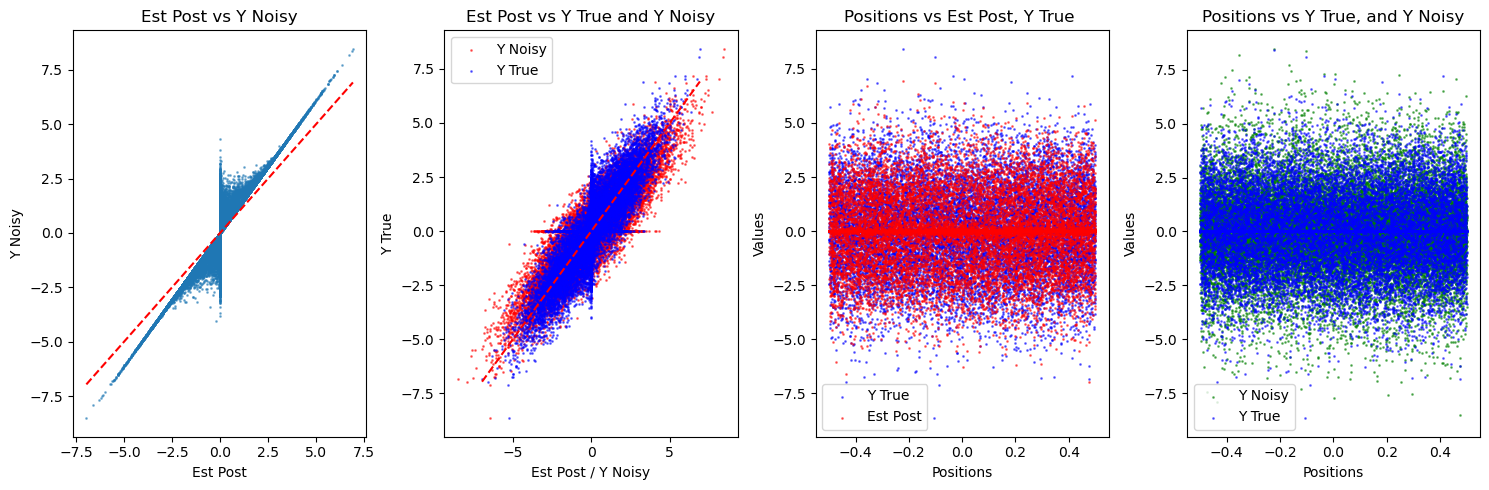


Mean Squared Error:
MSE (Y Noisy vs Y True): 0.9985
MSE (Est Post vs Y True): 0.5214


In [20]:
model.eval()
with torch.no_grad():
    train_loader = DataLoader(simulated_dataset, batch_size=128, shuffle=False)
    all_likelihoods = []
    all_positions = []
    all_y_true = []
    all_y_noisy = []
   
    for data, digit, pos, y_value, y_noisy, marginal_log_lik in train_loader:
        data, pos = data.to(device), pos.to(device)
        likelihood = model(data, pos.unsqueeze(1))
        all_likelihoods.append(likelihood.cpu().numpy())
        all_positions.append(pos.cpu().numpy())
        all_y_true.append(y_value.numpy())
        all_y_noisy.append(y_noisy.numpy())

all_likelihoods = np.concatenate(all_likelihoods)
all_positions = np.concatenate(all_positions)
all_y_true = np.concatenate(all_y_true)
all_y_noisy = np.concatenate(all_y_noisy)

# Compute posterior mean
est_post = np.zeros(len(all_y_noisy))
for i in range(len(all_y_noisy)):
    est_post[i] = posterior_mean_norm(
        betahat=np.array([all_y_noisy[i]]),
        sebetahat=np.array([noise_level]),
        log_pi=np.log(all_likelihoods[i, :]),
        scale=simulated_dataset.scale
    ).post_mean

# Plotting
plt.figure(figsize=(15, 5))

# Plot 1: Est Post vs Y Noisy
plt.subplot(1, 4, 1)
plt.scatter(est_post, all_y_noisy, alpha=0.5, s=1)
plt.title('Est Post vs Y Noisy')
plt.xlabel('Est Post')
plt.ylabel('Y Noisy')
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 2: Est Post vs Y True
plt.subplot(1, 4, 2)
plt.scatter(all_y_noisy, all_y_true, alpha=0.5, s=1, label='Y Noisy', color='red')

plt.scatter(est_post, all_y_true, alpha=0.5, s=1, label='Y True', color='blue')
plt.title('Est Post vs Y True and Y Noisy')
plt.xlabel('Est Post / Y Noisy')
plt.ylabel('Y True')
plt.legend()
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 3: Positions vs Est Post, Y True, and Y Noisy
plt.subplot(1, 4, 3)
plt.scatter(all_positions, all_y_true, alpha=0.5, s=1, label='Y True', color='blue')
plt.scatter(all_positions, est_post, alpha=0.5, s=1, label='Est Post', color='red') 
plt.title('Positions vs Est Post, Y True ')
plt.xlabel('Positions')
plt.ylabel('Values')
plt.legend()

plt.subplot(1, 4, 4)

plt.scatter(all_positions, all_y_noisy, alpha=0.5, s=1, label='Y Noisy', color='green')
plt.scatter(all_positions, all_y_true, alpha=0.5, s=1, label='Y True', color='blue') 
plt.title('Positions vs Y True, and Y Noisy')
plt.xlabel('Positions')
plt.ylabel('Values')
plt.legend()


plt.tight_layout()
plt.show()

 
# Calculate and print MSE
mse_noisy = np.mean((all_y_true - all_y_noisy)**2)
mse_est = np.mean((est_post - all_y_true)**2)
print(f"\nMean Squared Error:")
print(f"MSE (Y Noisy vs Y True): {mse_noisy:.4f}")
print(f"MSE (Est Post vs Y True): {mse_est:.4f}")

In [21]:
import sys
import os
import matplotlib.pyplot as plt

# Add the path to utils.py
sys.path.append(r"c:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
from distribution_operation import *
from utils import *
from numerical_routine import *
from posterior_computation import *
from ash import *
print(np.repeat(noise_level, y_noisy.shape[0]))
betahat =  np.array(simulated_dataset.y_noisy )

sebetahat =  np.repeat(noise_level, betahat.shape[0])
print(sebetahat)
res= ash(betahat=betahat,
         sebetahat= sebetahat, penalty=2)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 ... 1 1 1]
Iteration 0, Loss: 254.15622406549048
Iteration 100, Loss: 254.5941267673772
Iteration 200, Loss: 249.70036626071695
Iteration 300, Loss: 262.0078800437531
Iteration 400, Loss: 245.7442934236831


In [22]:
mse_ash = np.mean((res.post_mean - all_y_true)**2)
print(res.pi)

[3.47767429e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.37675620e-01 4.14556951e-01 3.51567029e-13
 3.09213972e-12 5.10862864e-12]


In [23]:
print(f"\nMean Squared Error:")
print(f"MSE (Y Noisy vs Y True): {mse_noisy:.4f}")
print(f"MSE (Est Post vs Y True): {mse_est:.4f}")
print(f"MSE (ash Est Post vs Y True): {mse_ash:.4f}")



Mean Squared Error:
MSE (Y Noisy vs Y True): 0.9985
MSE (Est Post vs Y True): 0.5214
MSE (ash Est Post vs Y True): 0.5947


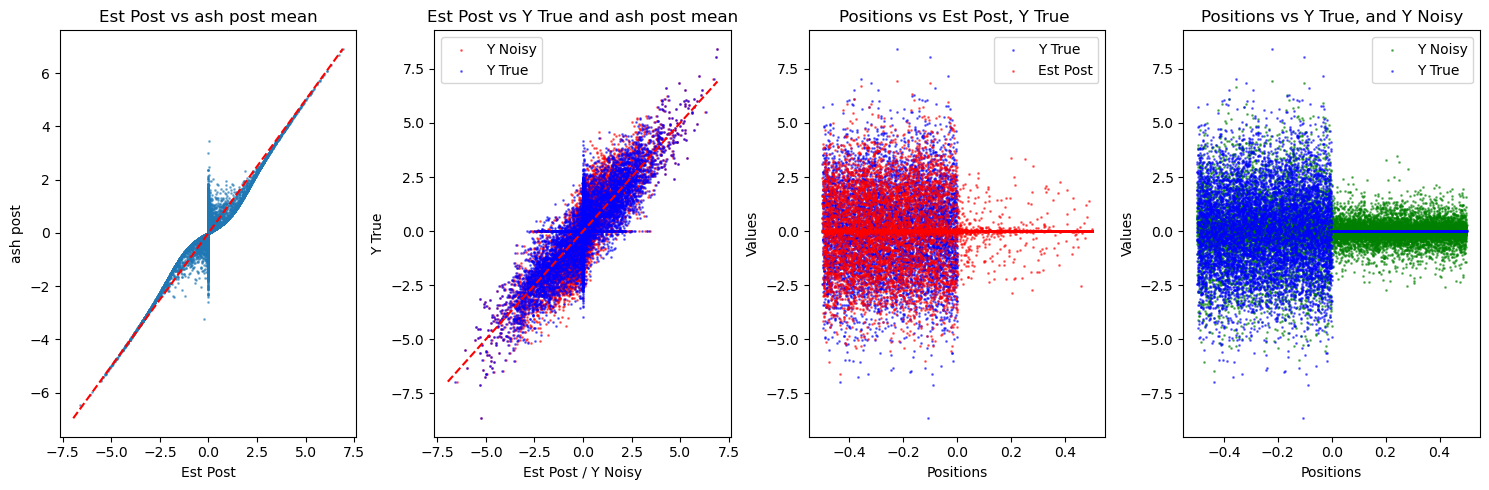


Mean Squared Error:
MSE (Y Noisy vs Y True): 1.0087
MSE (Est Post vs Y True): 0.5289
MSE (Est Post vs Y True): 0.5953


In [24]:

idx= simulated_dataset.label_type

# Plotting
plt.figure(figsize=(15, 5))

# Plot 1: Est Post vs Y Noisy
plt.subplot(1, 4, 1)
plt.scatter(est_post[idx],res.post_mean[idx], alpha=0.5, s=1)
plt.title('Est Post vs ash post mean')
plt.xlabel('Est Post')
plt.ylabel('ash post')
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 2: Est Post vs Y True
plt.subplot(1, 4, 2)
plt.scatter(res.post_mean[idx], all_y_true[idx], alpha=0.5, s=1, label='Y Noisy', color='red')

plt.scatter(est_post[idx], all_y_true[idx], alpha=0.5, s=1, label='Y True', color='blue')
plt.title('Est Post vs Y True and ash post mean')
plt.xlabel('Est Post / Y Noisy')
plt.ylabel('Y True')
plt.legend()
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 3: Positions vs Est Post, Y True, and Y Noisy
plt.subplot(1, 4, 3)
plt.scatter(all_positions[idx], all_y_true[idx], alpha=0.5, s=1, label='Y True', color='blue')
plt.scatter(all_positions[idx], est_post[idx], alpha=0.5, s=1, label='Est Post', color='red') 
plt.title('Positions vs Est Post, Y True ')
plt.xlabel('Positions')
plt.ylabel('Values')
plt.legend()

plt.subplot(1, 4, 4)

plt.scatter(all_positions[idx],res.post_mean[idx], alpha=0.5, s=1, label='Y Noisy', color='green')
plt.scatter(all_positions[idx], all_y_true[idx], alpha=0.5, s=1, label='Y True', color='blue') 
plt.title('Positions vs Y True, and Y Noisy')
plt.xlabel('Positions')
plt.ylabel('Values')
plt.legend()


plt.tight_layout()
plt.show()

 
# Calculate and print MSE

# Calculate and print MSE
mse_noisy = np.mean((all_y_true[idx] - all_y_noisy[idx])**2)
mse_est = np.mean((est_post[idx] - all_y_true[idx])**2)

mse_ash  = np.mean((res.post_mean[idx] - all_y_true[idx])**2)
print(f"\nMean Squared Error:")
print(f"MSE (Y Noisy vs Y True): {mse_noisy:.4f}")
print(f"MSE (Est Post vs Y True): {mse_est:.4f}")

print(f"MSE (Est Post vs Y True): {mse_ash:.4f}")

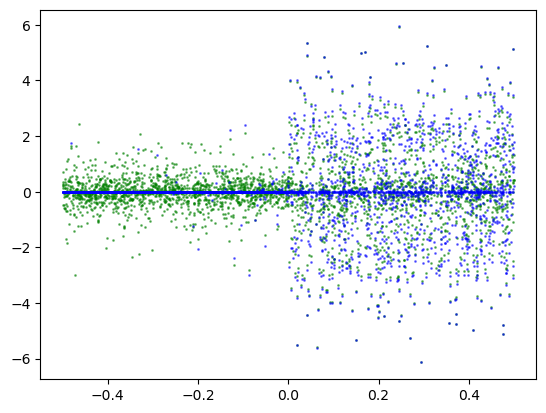

In [37]:
idx =simulated_dataset.image_label    ==7
plt.scatter(all_positions[idx],res.post_mean[idx], alpha=0.5, s=1, label='Y Noisy', color='green')
plt.scatter(all_positions[idx],est_post[idx], alpha=0.5, s=1, label='Y True', color='blue') 

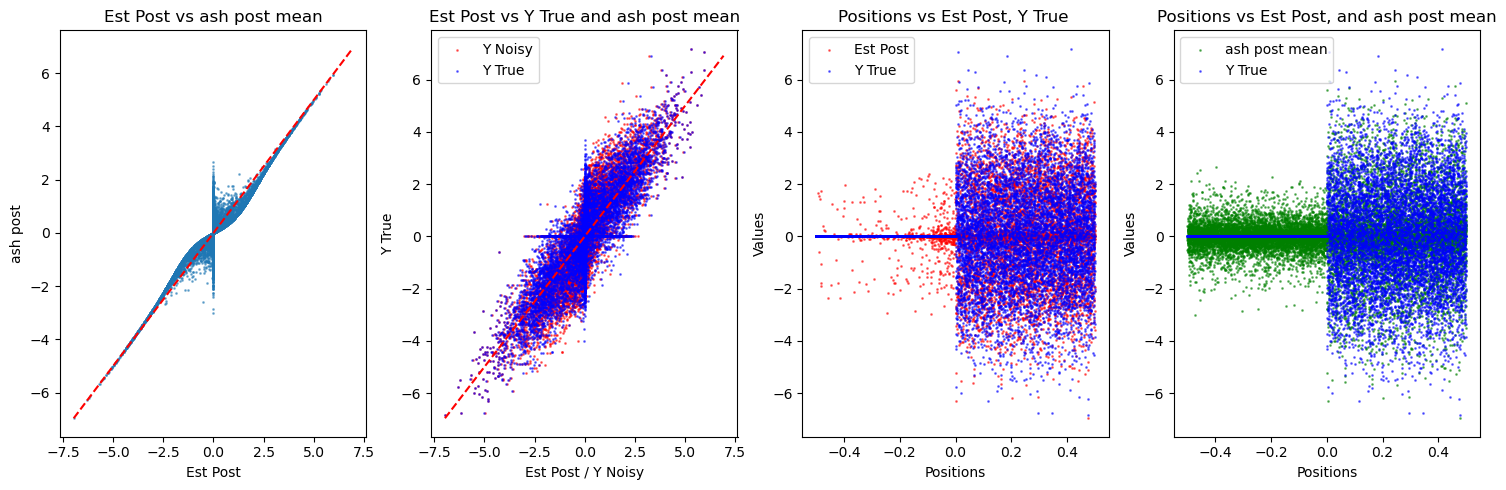


Mean Squared Error:
MSE (Y Noisy vs Y True): 0.9886
MSE (Est Post vs Y True): 0.5141
MSE (Est Post vs Y True): 0.5940


In [28]:

idx=  ~simulated_dataset.label_type
 
# Plotting
plt.figure(figsize=(15, 5))

# Plot 1: Est Post vs Y Noisy
plt.subplot(1, 4, 1)
plt.scatter(est_post[idx],res.post_mean[idx], alpha=0.5, s=1)
plt.title('Est Post vs ash post mean')
plt.xlabel('Est Post')
plt.ylabel('ash post')
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 2: Est Post vs Y True
plt.subplot(1, 4, 2)
plt.scatter(res.post_mean[idx], all_y_true[idx], alpha=0.5, s=1, label='Y Noisy', color='red')

plt.scatter(est_post[idx], all_y_true[idx], alpha=0.5, s=1, label='Y True', color='blue')
plt.title('Est Post vs Y True and ash post mean')
plt.xlabel('Est Post / Y Noisy')
plt.ylabel('Y True')
plt.legend()
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 3: Positions vs Est Post, Y True, and Y Noisy
plt.subplot(1, 4, 3)

plt.scatter(all_positions[idx], est_post[idx], alpha=0.5, s=1, label='Est Post', color='red') 
plt.scatter(all_positions[idx], all_y_true[idx], alpha=0.5, s=1, label='Y True', color='blue')
plt.title('Positions vs Est Post, Y True ')
plt.xlabel('Positions')
plt.ylabel('Values')
plt.legend()

plt.subplot(1, 4, 4)

plt.scatter(all_positions[idx],res.post_mean[idx], alpha=0.5, s=1, label='ash post mean', color='green')
plt.scatter(all_positions[idx], all_y_true[idx], alpha=0.5, s=1, label='Y True', color='blue') 
plt.title('Positions vs Est Post, and ash post mean')
plt.xlabel('Positions')
plt.ylabel('Values')
plt.legend()


plt.tight_layout()
plt.show()

 
# Calculate and print MSE

# Calculate and print MSE
mse_noisy = np.mean((all_y_true[idx] - all_y_noisy[idx])**2)
mse_est = np.mean((est_post[idx] - all_y_true[idx])**2)

mse_ash  = np.mean((res.post_mean[idx] - all_y_true[idx])**2)
print(f"\nMean Squared Error:")
print(f"MSE (Y Noisy vs Y True): {mse_noisy:.4f}")
print(f"MSE (Est Post vs Y True): {mse_est:.4f}")

print(f"MSE (Est Post vs Y True): {mse_ash:.4f}")